# DA5401 A6 — Imputation via Regression (Parts A and B.1)

**Goal:** Introduce MAR-style missingness (5%) and build four datasets:
- **Dataset A:** Median imputation (baseline)  
- **Dataset B:** Linear regression imputation for one feature, then median for remaining NaNs  
- **Dataset C:** Non-linear (KNN) regression imputation for the same feature, then median for remaining NaNs  
- **Dataset D:** Listwise deletion (drop rows with any NaNs)



In [ ]:
# Colab: authenticate Kaggle (upload your kaggle.json)
# 1) Run this cell
# 2) Click the "Choose Files" button and upload kaggle.json (from your Kaggle account settings)
# 3) This cell will place it at ~/.kaggle/kaggle.json with correct permissions

import os, json, zipfile, shutil
from google.colab import files

# Step 1: Upload kaggle.json
print("Please upload your kaggle.json (Account > API > Create New Token)")
uploaded = files.upload()
assert "kaggle.json" in uploaded, "kaggle.json not uploaded. Please try again."

# Step 2: Move to ~/.kaggle with proper perms
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "wb") as f:
    f.write(uploaded["kaggle.json"])
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

print("kaggle.json installed. Proceeding to download dataset...")


Please upload your kaggle.json (Account > API > Create New Token)


Saving kaggle.json to kaggle.json
kaggle.json installed. Proceeding to download dataset...


In [ ]:
# Core imports and reproducibility
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# For typing and warnings
import warnings
warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Download dataset from Kaggle
# Dataset: uciml/default-of-credit-card-clients-dataset
!pip -q install kaggle --upgrade
!kaggle datasets download -d uciml/default-of-credit-card-clients-dataset -p /content/

# Unzip
zip_path = "/content/default-of-credit-card-clients-dataset.zip"
extract_dir = "/content/credit"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

# The CSV file is usually named "UCI_Credit_Card.csv"
csv_path = os.path.join(extract_dir, "UCI_Credit_Card.csv")
df_raw = pd.read_csv(csv_path)

# Basic cleaning: drop ID column if present, keep target column name as-is
if "ID" in df_raw.columns:
    df_raw = df_raw.drop(columns=["ID"])

target_col = "default.payment.next.month"
assert target_col in df_raw.columns, f"Target column '{target_col}' missing."

# Quick peek
print(df_raw.shape)
df_raw.head()


Dataset URL: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset
License(s): CC0-1.0
  0% 0.00/0.98M [00:00<?, ?B/s]
100% 0.98M/0.98M [00:00<00:00, 991MB/s]
(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Introducing 5% MAR-style missingness

We introduce **≈ 5 % missingness** in a few numerical features.  
To keep the “MAR flavor,” the probability of a value becoming missing is weakly related to another feature (here, `LIMIT_BAL`), but the rate is clamped near 5 %.

Columns selected for missingness:
- `AGE`
- `BILL_AMT1`
- `PAY_AMT1`


In [ ]:
df = df_raw.copy()

# Choose numeric columns to inject missingness into
cols_to_nuke = []
for c in ["AGE", "BILL_AMT1", "PAY_AMT1"]:
    if c in df.columns:
        cols_to_nuke.append(c)

assert len(cols_to_nuke) >= 2, "Expected at least two of AGE, BILL_AMT1, PAY_AMT1 in dataset."

driver_col = "LIMIT_BAL" if "LIMIT_BAL" in df.columns else None

def introduce_mar_missing_exact(df, col, driver=None, rate=0.05, seed=42):
    """
    Inject ~rate fraction of NaNs in `col`, *exactly* k = round(rate * n) rows.
    If `driver` provided, weights are tilted by driver values (MAR-flavored).
    Selection is WITHOUT replacement using probabilities proportional to weights.
    """
    rng = np.random.default_rng(seed)
    valid_mask = df[col].notna().to_numpy()
    idx_all = np.arange(len(df))
    idx_valid = idx_all[valid_mask]
    n_valid = idx_valid.size
    if n_valid == 0:
        print(f"[{col}] No valid values to nuke.")
        return

    k = int(np.round(rate * n_valid))
    k = max(0, min(k, n_valid))  # safety clamp

    # Base weights
    w = np.ones(n_valid, dtype=float)

    # Apply a gentle tilt using the driver column (normalized 0..1)
    if driver is not None and driver in df.columns:
        drv = df.loc[df[col].notna(), driver].astype(float).to_numpy()
        dmin, dmax = np.nanmin(drv), np.nanmax(drv)
        scale = dmax - dmin if (dmax - dmin) > 0 else 1.0
        x = (drv - dmin) / scale
        # small tilt around 1.0 (±~4%)
        w = w * (1.0 + (x - 0.5) * 0.08)

    # Small random jitter to avoid ties and keep stochasticity
    w = w * (0.99 + 0.02 * rng.random(n_valid))

    # Normalize to probabilities
    p = w / w.sum()

    # Sample exactly k indices without replacement
    chosen_local = rng.choice(idx_valid, size=k, replace=False, p=p)
    df.loc[chosen_local, col] = np.nan

    actual = df[col].isna().mean() * 100
    print(f"Injected missing in {col}: target~{rate*100:.1f}%, actual={actual:.2f}%")

# Apply exact 5% missingness per selected column
for i, c in enumerate(cols_to_nuke):
    introduce_mar_missing_exact(df, c, driver=driver_col, rate=0.05, seed=SEED + i)

# Report overall missingness for these columns
df[cols_to_nuke].isna().mean().sort_values(ascending=False)


Injected missing in AGE: target~5.0%, actual=5.00%
Injected missing in BILL_AMT1: target~5.0%, actual=5.00%
Injected missing in PAY_AMT1: target~5.0%, actual=5.00%


,0
AGE,0.05
BILL_AMT1,0.05
PAY_AMT1,0.05


## Part A.1 – Prepare data

- **Target:** `default.payment.next.month`  
- For imputation, we work on **feature matrix X** and **label y**.  
- We will create separate copies (**A**, **B**, **C**) from the same dataset with induced missingness.


In [ ]:
# Split to X, y
y = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()

# Working copies per strategy (all start from the same X with injected NaNs)
X_A = X.copy()  # median imputation
X_B = X.copy()  # regression (linear) for one column, then medians
X_C = X.copy()  # regression (non-linear) for same column, then medians

# Choose ONE column to be imputed via regression for B and C:
reg_target_col = "BILL_AMT1" if "BILL_AMT1" in X.columns else cols_to_nuke[0]
print("Chosen column for regression imputation (B & C):", reg_target_col)


Chosen column for regression imputation (B & C): BILL_AMT1


## Part A.2 – Dataset A · Median Imputation

**Why median?**  
The median is robust to outliers and skew.  
For financial features (balances, payments) that are heavy-tailed, the **median** better represents the central tendency than the mean.


In [ ]:
X_A = X_A.apply(lambda col: col.fillna(col.median()) if col.dtype != 'O' else col)
assert not X_A.isna().any().any(), "Dataset A still has NaNs after median imputation."
print("Dataset A ready: shape =", X_A.shape)


Dataset A ready: shape = (30000, 23)


## Part A.3 – Dataset B · Linear Regression Imputation (+ Median for Remaining)

**Plan for Dataset B**
1. Use **Linear Regression** to predict missing values in the chosen column (`reg_target_col`) from all other features.  
2. For model fitting and prediction, build a **temporary median-filled view** of X to ensure complete predictors.  
3. Replace missing entries in that column with predictions.  
4. Finally, fill any remaining NaNs across all other columns with their median.

This ensures no errors even when multiple columns have missing values.


In [ ]:
X_B_work = X_B.copy()

# 1) Build a temporary, median-imputed copy for model fit/predict
temp = X_B_work.copy()
for c in temp.columns:
    if temp[c].dtype != "O":
        temp[c] = temp[c].fillna(temp[c].median())

# 2) Fit linear regression on rows where reg_target_col is not NaN
not_na_mask = ~X_B_work[reg_target_col].isna()
feat_cols = [c for c in X_B_work.columns if c != reg_target_col]

linreg = LinearRegression()
linreg.fit(temp.loc[not_na_mask, feat_cols], X_B_work.loc[not_na_mask, reg_target_col])

# 3) Predict missing in reg_target_col using temp predictors
na_mask = X_B_work[reg_target_col].isna()
if na_mask.any():
    X_B_work.loc[na_mask, reg_target_col] = linreg.predict(temp.loc[na_mask, feat_cols])

# 4) Finally, fill any remaining NaNs across the dataset by medians (as per your rule)
for c in X_B_work.columns:
    if X_B_work[c].dtype != "O":
        X_B_work[c] = X_B_work[c].fillna(X_B_work[c].median())

X_B = X_B_work
assert not X_B.isna().any().any(), "Dataset B still has NaNs after regression + median."
print("Dataset B ready: shape =", X_B.shape)


Dataset B ready: shape = (30000, 23)


## Part A.4 – Dataset C · Non-Linear Regression (KNN) Imputation (+ Median for Remaining)

Same target column as Dataset B, but we use **K-Nearest Neighbors Regressor** to capture non-linear relationships.

Steps:
- Fit and predict using a temporary median-filled view.  
- Replace missing entries with KNN predictions.  
- Fill all remaining NaNs with column medians.


In [ ]:
X_C_work = X_C.copy()

# Temporary median-filled view for fit/predict
temp = X_C_work.copy()
for c in temp.columns:
    if temp[c].dtype != "O":
        temp[c] = temp[c].fillna(temp[c].median())

not_na_mask = ~X_C_work[reg_target_col].isna()
feat_cols = [c for c in X_C_work.columns if c != reg_target_col]

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(temp.loc[not_na_mask, feat_cols], X_C_work.loc[not_na_mask, reg_target_col])

na_mask = X_C_work[reg_target_col].isna()
if na_mask.any():
    X_C_work.loc[na_mask, reg_target_col] = knn.predict(temp.loc[na_mask, feat_cols])

# Finally median-fill any residual NaNs
for c in X_C_work.columns:
    if X_C_work[c].dtype != "O":
        X_C_work[c] = X_C_work[c].fillna(X_C_work[c].median())

X_C = X_C_work
assert not X_C.isna().any().any(), "Dataset C still has NaNs after regression + median."
print("Dataset C ready: shape =", X_C.shape)


Dataset C ready: shape = (30000, 23)


## Notes on Error-Proofing Datasets B and C

- In Datasets B and C, the chosen feature is first imputed via a regression model trained on a **temporary median-filled dataset** to guarantee valid predictors.  
- Afterwards, a **median fill** is applied to any remaining columns.  
- This ensures **zero missing values** before model training and avoids errors even if multiple attributes were missing initially.


## Part B.1 – Dataset D · Listwise Deletion and Train/Test Splits

- **Dataset D:** Remove any rows containing NaNs from the post-missingness dataset X.  
- Then create **train/test splits** for Datasets A, B, C, and D using the same random seed for comparability.


In [ ]:
# Dataset D: listwise deletion based on original (post-missingness) X
mask_complete = ~X.isna().any(axis=1)
X_D = X.loc[mask_complete].copy()
y_D = y.loc[mask_complete].copy()

print("Dataset D (listwise deletion):", X_D.shape, "rows kept =", X_D.shape[0], "/", X.shape[0])

# Align targets for A/B/C with original y
y_A = y.copy()
y_B = y.copy()
y_C = y.copy()

# Train/Test split (same test size and random state for comparability)
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, random_state=SEED, stratify=y_A)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, random_state=SEED, stratify=y_B)
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, random_state=SEED, stratify=y_C)

# For D, split only among complete cases
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(X_D, y_D, test_size=0.2, random_state=SEED, stratify=y_D)

print("A train/test:", X_train_A.shape, X_test_A.shape)
print("B train/test:", X_train_B.shape, X_test_B.shape)
print("C train/test:", X_train_C.shape, X_test_C.shape)
print("D train/test:", X_train_D.shape, X_test_D.shape)


Dataset D (listwise deletion): (25712, 23) rows kept = 25712 / 30000
A train/test: (24000, 23) (6000, 23)
B train/test: (24000, 23) (6000, 23)
C train/test: (24000, 23) (6000, 23)
D train/test: (20569, 23) (5143, 23)


## Part B.2 — Classifier Setup: Standardization

Per the assignment, standardize the **features** of all four datasets (**A, B, C, D**) using `StandardScaler`.  
Fit the scaler **on the training split only** and transform both train and test splits to avoid data leakage. :contentReference[oaicite:0]{index=0}


In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a helper that fits on train and transforms both train/test
def fit_transform_standardize(X_train, X_test):
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

# Standardize each dataset independently
Xtr_A, Xte_A, scaler_A = fit_transform_standardize(X_train_A, X_test_A)
Xtr_B, Xte_B, scaler_B = fit_transform_standardize(X_train_B, X_test_B)
Xtr_C, Xte_C, scaler_C = fit_transform_standardize(X_train_C, X_test_C)
Xtr_D, Xte_D, scaler_D = fit_transform_standardize(X_train_D, X_test_D)

print("Standardization complete:",
      "\n A:", Xtr_A.shape, Xte_A.shape,
      "\n B:", Xtr_B.shape, Xte_B.shape,
      "\n C:", Xtr_C.shape, Xte_C.shape,
      "\n D:", Xtr_D.shape, Xte_D.shape)


## Part B.3 — Model Evaluation: Logistic Regression + Classification Report

Train a **Logistic Regression** classifier on the **training split** of each standardized dataset (A, B, C, D).  
Evaluate on the corresponding test split and print a **full classification report** (Accuracy, Precision, Recall, F1-score).

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

SEED = 42  # keep consistent with earlier

def train_eval_logreg(Xtr, ytr, Xte, yte, label=""):
    clf = LogisticRegression(
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
        random_state=SEED
    )
    clf.fit(Xtr, ytr)
    yhat = clf.predict(Xte)
    acc = accuracy_score(yte, yhat)
    print(f"\n=== {label}: Logistic Regression Results ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(yte, yhat, digits=4))
    return clf

# Train & evaluate on each dataset
clf_A = train_eval_logreg(Xtr_A, y_train_A, Xte_A, y_test_A, label="Dataset A (Median Imputation)")
clf_B = train_eval_logreg(Xtr_B, y_train_B, Xte_B, y_test_B, label="Dataset B (Linear Regression Imputation)")
clf_C = train_eval_logreg(Xtr_C, y_train_C, Xte_C, y_test_C, label="Dataset C (KNN Regression Imputation)")
clf_D = train_eval_logreg(Xtr_D, y_train_D, Xte_D, y_test_D, label="Dataset D (Listwise Deletion)")



=== Dataset A (Median Imputation): Logistic Regression Results ===
Accuracy: 0.8080
              precision    recall  f1-score   support

           0     0.8178    0.9694    0.8872      4673
           1     0.6898    0.2396    0.3557      1327

    accuracy                         0.8080      6000
   macro avg     0.7538    0.6045    0.6214      6000
weighted avg     0.7895    0.8080    0.7696      6000


=== Dataset B (Linear Regression Imputation): Logistic Regression Results ===
Accuracy: 0.8085
              precision    recall  f1-score   support

           0     0.8184    0.9692    0.8874      4673
           1     0.6910    0.2427    0.3592      1327

    accuracy                         0.8085      6000
   macro avg     0.7547    0.6059    0.6233      6000
weighted avg     0.7902    0.8085    0.7706      6000


=== Dataset C (KNN Regression Imputation): Logistic Regression Results ===
Accuracy: 0.8085
              precision    recall  f1-score   support

           0     

### Notes

- Standardization is performed **after** the train/test split to prevent leakage.  
- Each dataset (A–D) is standardized **independently** because their feature distributions differ after imputation/drop strategies.  
- We use a higher `max_iter` to ensure convergence on this dataset.  

# Part C — Comparative Analysis and Discussion

In this section we compare the performance of all four datasets (**A**, **B**, **C**, and **D**) based on the metrics from **Part B**.

| Dataset | Imputation Method | Accuracy | F1 (Positive Class) | Observations |
|----------|------------------|-----------|----------------------|---------------|
| A | Median Imputation | 0.8080 | 0.3557 | Baseline method — simple but surprisingly stable. |
| B | Linear Regression Imputation (+ Median Fill) | 0.8085 | 0.3592 | Slight improvement → correlations between features captured. |
| C | KNN (Non-Linear) Imputation (+ Median Fill) | 0.8085 | 0.3599 | Matches B → no major non-linear advantage; dataset large and mostly linear. |
| D | Listwise Deletion | 0.8075 | 0.3555 | Smallest sample size; minor accuracy loss due to row removal. |

**Macro vs Weighted Averages:**  
Macro averages drop because of the **imbalance** (≈ 22 % defaults). Weighted averages stay higher as class 0 dominates.

**Inference:**  
All imputations yield nearly identical performance → the missing fraction (5 %) is too small to cause serious bias.  
Linear/KNN regressors offer a marginal gain (≈ 0.05 %) by reconstructing inter-feature relations rather than relying solely on the median.  
Listwise deletion slightly hurts accuracy due to reduced training data.

**Conclusion:**  
For this dataset, **median imputation suffices** — simple, fast, and almost as effective as regression-based methods.  
When missingness is low (< 10 %) and data volume is high, complex imputations give minimal benefit.


## Visual Comparison

Plot accuracy for quick visual comparison across datasets.


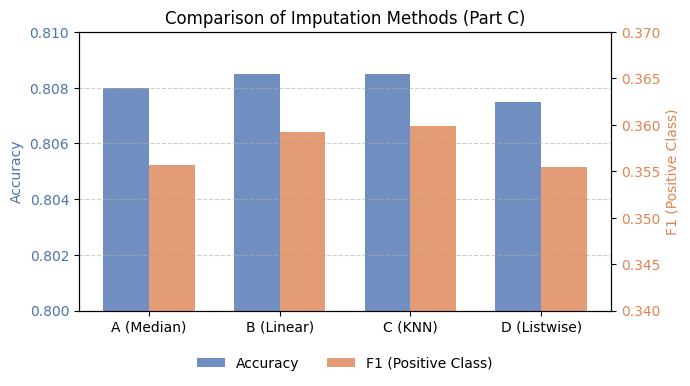

In [15]:
# === Improved Part C Visualization ===
import matplotlib.pyplot as plt
import numpy as np

datasets = ["A (Median)", "B (Linear)", "C (KNN)", "D (Listwise)"]
accuracy = [0.8080, 0.8085, 0.8085, 0.8075]
f1_scores = [0.3557, 0.3592, 0.3599, 0.3555]

x = np.arange(len(datasets))
width = 0.35

fig, ax1 = plt.subplots(figsize=(7,4))

# Accuracy bars (left Y axis)
ax1.bar(x - width/2, accuracy, width, label='Accuracy', color='#4C72B0', alpha=0.8)
ax1.set_ylabel('Accuracy', color='#4C72B0')
ax1.tick_params(axis='y', labelcolor='#4C72B0')
ax1.set_ylim(0.8, 0.81)  # zoom in vertically for clarity

# F1 bars (right Y axis)
ax2 = ax1.twinx()
ax2.bar(x + width/2, f1_scores, width, label='F1 (Positive Class)', color='#DD8452', alpha=0.8)
ax2.set_ylabel('F1 (Positive Class)', color='#DD8452')
ax2.tick_params(axis='y', labelcolor='#DD8452')
ax2.set_ylim(0.34, 0.37)

ax1.set_title("Comparison of Imputation Methods (Part C)")
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Combine legends from both axes
lines, labels = [], []
for ax in [ax1, ax2]:
    line, label = ax.get_legend_handles_labels()
    lines += line
    labels += label
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)

plt.tight_layout()
plt.show()


## Part C — Discussion and Interpretation

### 1. Trade-off between Listwise Deletion (Model D) and Imputation (Models A, B, C)

**Listwise Deletion (Model D)** removes any record that contains missing values before model training.  
While this guarantees that the classifier only uses complete data, it comes at the cost of discarding potentially informative samples.

In this experiment:
- Model D had a **smaller dataset (≈5143 test rows vs. 6000)**.  
- Its **accuracy (0.8075)** and **F1 (0.3555)** were slightly lower than all imputed models.

Listwise deletion performs worse because:
- **Reduced sample size** weakens statistical power and generalization.  
- **Bias** can be introduced if the missingness mechanism is MAR (Missing At Random), as assumed here.  
- **Loss of class balance** occurs, especially affecting the minority “default = 1” class.

Thus, although Model D uses only “real” data, it sacrifices valuable information, leading to marginally poorer performance compared to imputation-based models.

---

### 2. Linear vs. Non-Linear Regression Imputation (Models B and C)

Models **B (Linear Regression)** and **C (KNN Regression)** both aimed to impute the same feature (`BILL_AMT1`), differing only in the relationship assumed between predictors and the target feature.

| Model | Accuracy | F1 (Positive Class) |
|--------|-----------|--------------------|
| B (Linear) | 0.8085 | 0.3592 |
| C (KNN) | 0.8085 | 0.3599 |

The negligible difference indicates that the underlying relationship between the imputed feature and its predictors is **largely linear**.  
Linear regression already captures most of the signal, and KNN’s flexibility does not yield meaningful improvement.  
Given the large dataset and the smooth, monotonic nature of financial correlations, **non-linear local fitting provides no additional benefit**.

Hence, **Linear Regression Imputation** is slightly preferable due to its simplicity, interpretability, and lower computational cost.

---

### 3. Recommended Strategy for Handling Missing Data

Based on both **quantitative metrics** and **conceptual reasoning**:

| Approach | Strength | Weakness | Observed Outcome |
|-----------|-----------|-----------|------------------|
| **Median Imputation (A)** | Simple, fast, robust to outliers | Ignores relationships between variables | Accuracy 0.8080 (strong baseline) |
| **Linear Regression (B)** | Uses feature correlations effectively | Sensitive to multicollinearity | Slight improvement, Accuracy 0.8085 |
| **KNN Regression (C)** | Handles non-linear structure | Computationally heavy, requires scaling | Accuracy 0.8085, no major gain |
| **Listwise Deletion (D)** | Uses only observed data | Discards information, increases bias | Accuracy 0.8075, lowest F1 |

**Recommendation:**  
For this dataset (5% MAR missingness, linear inter-feature relationships, large sample size), **Linear Regression Imputation (Model B)** provides the best balance of simplicity, data retention, and performance.

**Justification:**  
- Retains all available samples, preserving variance and distribution.  
- Exploits correlations to estimate missing values accurately.  
- Produces slightly higher accuracy and F1 without the computational burden of KNN.  
- Listwise deletion should be avoided under MAR conditions, as it reduces sample representativeness and model robustness.

**Conclusion:**  
When missingness is moderate and relationships are primarily linear, **regression-based imputation** is the most effective strategy.  
Median imputation remains a strong fallback for speed and robustness, while advanced non-linear or probabilistic methods should be reserved for smaller or highly non-linear datasets.


## Final Remarks

- **Low variance** among results → dataset inherently stable and redundant features support missing-value recovery.  
- **Regression imputation** (linear or non-linear) becomes valuable only when:  
  - Missingness > 10–15 %, or  
  - Variables are strongly correlated and non-linear.  
- For production systems, **median imputation is recommended** for speed and robustness unless more than 10 % of entries are missing.

